# LC3 DATA ANALYSIS

### Load libraries and data

In [1]:
# Libraries for general data management
import pandas as pd
import numpy as np

In [142]:
# Libraries for creating and validating models
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.impute import SimpleImputer

In [35]:
# Libraries for data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [36]:
# Library for iterations
from itertools import combinations 

In [4]:
%matplotlib inline
import seaborn as sns
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
# Input file path (can be also an excel)
DATA_PATH = './data/data_merged.ods'

In [47]:
# Read data skipping the first row and considering '-' as NaN
data = pd.read_excel(DATA_PATH, skiprows=[0], na_values=['-'], engine="odf")

df = data.copy()

df.rename(columns = {'Calcined kaolinite content (%)':'Calcined_kaolinite_content'}, inplace = True)
df.rename(columns = {'Dv,50 (µm)':'Dv_50'}, inplace = True)
df.rename(columns = {'BET Specific surface (m2/g)':'BET_Specific_surface'}, inplace = True)
for i in [1, 3, 7, 28, 90]:
    df.rename(columns = {f"{i}D": f"day_{i}"}, inplace = True)

df.sample(3)

,Clay,day_1,STD,day_3,STD.1,day_7,STD.2,day_28,STD.3,day_90,...,CaO,MgO,SO3,Na2O,K2O,TiO2,P2O5,MnO,Others,LOI
1,B45 India3 750°C,9.403125,0.189520,21.560417,1.963092,29.157500,0.868001,37.515625,0.555407,40.345312,...,0.600000,0.700000,NaN,0.100000,2.300000,0.800000,0.100000,0.1,0.200000,0.500000
45,Iran Z1,10.798437,0.163518,20.959837,0.088388,35.869816,0.265165,56.700249,0.402167,58.941642,...,1.084783,0.333696,0.094565,0.054348,0.535870,NaN,0.338043,NaN,0.548913,1.586957
32,Lakshmi2,11.884565,0.000000,29.444293,0.166340,44.505135,0.713327,54.861866,1.674050,56.854083,...,0.136364,0.357955,NaN,0.132955,1.515909,1.248864,0.262500,NaN,NaN,1.687409


### Visualize data

In [30]:
# Take kaolinite and compression strength
x = df['Calcined_kaolinite_content'].values # (Pandas dataframe).values = numpy array
y1  = df[ "day_1"].values
y3  = df[ "day_3"].values
y7  = df[ "day_7"].values
y28 = df["day_28"].values
y90 = df["day_90"].values

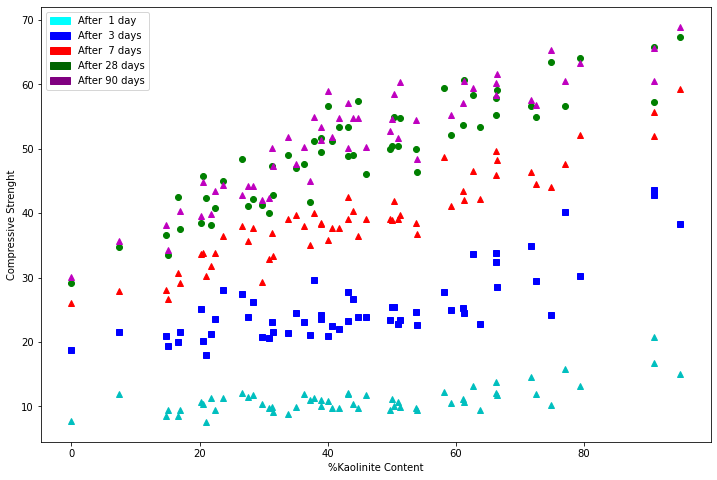

In [11]:
# Show points using matplotlib.pyplot library
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(x,y1,'c^',x,y3,'bs',x,y7,'r^',x,y28,'go', x,y90,'m^')
plt.xlabel('%Kaolinite Content')
plt.ylabel('Compressive Strenght')

d1_patch  = mpatches.Patch(color='cyan',      label='After  1 day')
d3_patch  = mpatches.Patch(color='blue',      label='After  3 days')
d7_patch  = mpatches.Patch(color='red',       label='After  7 days')
d28_patch = mpatches.Patch(color='darkgreen', label='After 28 days')
d90_patch = mpatches.Patch(color='purple',    label='After 90 days')
plt.legend(handles=[d1_patch,d3_patch,d7_patch,d28_patch,d90_patch])

plt.show()

### Data correlation analysis

In [12]:
# Function to hightlight high correlated cells in red
def highlight_high_correlations(cell):
    return 'background-color: %s' % ('red' if (cell != 1 and abs(cell) > CORRELATION_THRESHOLD) else 'white')

In [13]:
# Correlation between Compression Strength measurements and clays properties
CORRELATION_THRESHOLD = 0.6

corr_matrix = df.corr()[10:].iloc[:, 0:9]
corr_matrix.style.applymap(highlight_high_correlations)

,1D,STD,3D,STD.1,7D,STD.2,28D,STD.3,90D
Calcined_kaolinite_content,0.672115,0.082912,0.772572,0.444221,0.931003,0.177116,0.898135,0.328974,0.910680
"Dv,50",-0.111246,-0.118125,-0.011320,-0.129720,-0.116061,-0.113932,-0.146193,-0.185816,-0.152193
D10,-0.274278,-0.159055,-0.351558,-0.401368,-0.296297,-0.215840,-0.287737,-0.224444,-0.290692
D90,-0.225330,-0.018398,-0.169381,-0.070994,-0.147715,-0.032689,-0.131897,-0.082954,-0.141472
Span (-),-0.008618,0.020704,0.096408,0.055594,0.176071,0.044010,0.178734,0.022846,0.099044
BET_Specific_surface,-0.077832,-0.345532,-0.032558,0.010624,0.083831,-0.092784,0.108786,0.131376,0.198791
SiO2,-0.430950,0.006149,-0.443933,-0.302855,-0.563664,-0.086754,-0.579837,-0.322744,-0.635442
Al2O3,0.614406,0.029920,0.705345,0.394946,0.834569,0.248389,0.809226,0.322680,0.845753
Fe2O3,-0.268702,-0.137893,-0.284461,-0.100728,-0.265054,-0.108874,-0.259344,0.004947,-0.242389
CaO,-0.171936,0.140246,-0.143753,0.012872,-0.217687,-0.146547,-0.181013,-0.101726,-0.136114


In [14]:
# Correlation between clays properties themselves
CORRELATION_THRESHOLD = 0.75

corr_matrix = df.corr()[10:].iloc[:, 10:]
corr_matrix.style.applymap(highlight_high_correlations)

,Calcined_kaolinite_content,"Dv,50",D10,D90,Span (-),BET_Specific_surface,SiO2,Al2O3,Fe2O3,CaO,MgO,SO3,Na2O,K2O,TiO2,P2O5,MnO,Others,LOI
Calcined_kaolinite_content,1.000000,-0.193500,-0.305015,-0.244189,0.084792,0.091568,-0.662171,0.916967,-0.253895,-0.201540,-0.334250,0.015434,-0.197303,-0.411571,0.415086,-0.036408,0.318173,0.023426,0.232083
"Dv,50",-0.193500,1.000000,0.451829,0.776255,0.119163,-0.015583,0.287292,-0.242921,-0.189271,0.042118,0.052258,0.077456,-0.096222,0.074709,-0.006009,0.385650,0.255514,-0.084343,-0.230361
D10,-0.305015,0.451829,1.000000,-0.035547,-0.436280,-0.404479,0.382222,-0.145179,-0.431953,-0.214363,-0.187739,0.225985,0.012912,0.618675,-0.589368,0.378885,-0.771972,-0.200548,-0.064193
D90,-0.244189,0.776255,-0.035547,1.000000,0.736569,-0.089815,0.193764,-0.340139,-0.028480,0.342000,0.365395,0.975371,-0.132507,0.047146,-0.043585,0.138796,-0.142464,-0.011756,-0.171109
Span (-),0.084792,0.119163,-0.436280,0.736569,1.000000,0.101806,-0.072553,-0.042011,0.082441,0.072997,-0.075898,0.033117,-0.094787,-0.161342,0.197525,-0.029135,0.115944,-0.168370,-0.043502
BET_Specific_surface,0.091568,-0.015583,-0.404479,-0.089815,0.101806,1.000000,-0.421059,0.052440,0.619421,-0.100527,0.147891,-0.151082,-0.016290,-0.183056,0.099011,-0.142684,0.643980,-0.342051,0.152745
SiO2,-0.662171,0.287292,0.382222,0.193764,-0.072553,-0.421059,1.000000,-0.725183,-0.364198,-0.108063,-0.181542,-0.208559,-0.144506,0.130411,-0.410854,-0.038594,-0.305488,0.057821,-0.390461
Al2O3,0.916967,-0.242921,-0.145179,-0.340139,-0.042011,0.052440,-0.725183,1.000000,-0.282481,-0.211962,-0.286575,-0.169586,-0.213801,-0.315134,0.369314,-0.051612,0.372933,-0.036482,0.308423
Fe2O3,-0.253895,-0.189271,-0.431953,-0.028480,0.082441,0.619421,-0.364198,-0.282481,1.000000,0.004174,0.231275,0.008352,0.158245,-0.114540,0.208177,0.095215,0.104339,-0.108749,-0.060084
CaO,-0.201540,0.042118,-0.214363,0.342000,0.072997,-0.100527,-0.108063,-0.211962,0.004174,1.000000,0.569413,0.625109,0.496111,-0.086462,-0.304487,-0.135553,-0.081563,0.128110,0.067826


In [49]:
# Relevant clay properties, first row show the number of non missing values
data_restricted = df[['Calcined_kaolinite_content', 'Dv_50', 'BET_Specific_surface', 'Al2O3', 'Fe2O3', 'CaO', 'MgO', 'K2O', 'TiO2']]
data_restricted.describe()

,Calcined_kaolinite_content,Dv_50,BET_Specific_surface,Al2O3,Fe2O3,CaO,MgO,K2O,TiO2
count,58.000000,49.000000,48.000000,57.000000,57.000000,48.000000,50.000000,57.000000,55.000000
mean,44.574828,10.528980,19.918333,27.802180,5.708837,1.033639,0.586760,1.241594,1.260112
std,21.729599,7.300482,14.441748,8.750739,5.298461,1.785167,0.598484,1.598637,0.766232
min,0.000000,3.300000,1.200000,10.680412,0.300000,0.050000,0.054522,0.050000,0.000000
25%,28.675000,5.300000,11.575000,21.635000,1.056000,0.114250,0.232021,0.108247,0.726091
50%,42.465000,7.800000,15.900000,26.700000,4.529000,0.310038,0.383739,0.535870,1.100000
75%,60.610000,13.300000,23.525000,35.050000,8.900000,0.895421,0.696000,2.158000,1.800000
max,95.000000,29.700000,71.700000,43.800000,20.853000,7.719000,2.641000,9.314000,3.546000


In [16]:
# Leave one out cross validation for linear regression model considering only Kaolinite content
def leave_one_out_validation(x, y, model=LinearRegression()):
    l  = []
    cv = LeaveOneOut()
    for train_ix, test_ix in cv.split(x):
        x_train, x_test = x[train_ix], x[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]

        model.fit(x_train, y_train)
    
        y_pred = model.predict(x_test)


        l.append(mean_squared_error(y_test, y_pred))
    
    print("Model mean squared error: "+ str(sum(l)/len(l)))
   

In [17]:
# Add ones column to have w0 variable also in the linear regression
x = np.c_[np.ones(x.shape[0]), x]

In [18]:
leave_one_out_validation(x, y1)

Model mean squared error: 2.966931960885788


In [19]:
leave_one_out_validation(x, y3)

Model mean squared error: 14.108778240146801


In [20]:
leave_one_out_validation(x, y7)

Model mean squared error: 7.039998611976819


In [21]:
leave_one_out_validation(x, y28)

Model mean squared error: 14.414074644925595


In [22]:
# We have to handle NaN
#leave_one_out_validation(x, y90)

In [33]:
data_restricted

,Calcined_kaolinite_content,"Dv,50",BET_Specific_surface,Al2O3,Fe2O3,CaO,MgO,K2O,TiO2
0,0.00,11.20,1.20,NaN,NaN,NaN,NaN,0.100000,NaN
1,17.00,5.90,18.70,17.500000,8.900000,0.600000,0.700000,2.300000,0.800000
2,35.00,23.50,18.50,22.600000,6.100000,0.500000,NaN,0.300000,1.500000
3,50.30,10.90,45.70,32.300000,15.400000,1.300000,0.800000,0.200000,2.400000
4,66.20,4.00,12.90,42.700000,0.600000,NaN,NaN,0.100000,1.800000
5,79.40,5.30,15.30,42.400000,1.900000,0.100000,0.100000,0.100000,2.400000
6,95.00,5.10,9.60,43.800000,0.300000,NaN,NaN,0.100000,1.500000
7,38.90,8.50,23.10,26.800000,13.600000,0.300000,1.000000,0.400000,1.100000
8,66.20,4.00,12.90,42.700000,0.600000,NaN,NaN,0.100000,1.800000
9,51.26,7.80,9.20,33.095000,4.012000,0.122000,0.079000,0.245000,2.191000


In [32]:
mod = smf.ols(formula='day_1 ~ Calcined_kaolinite_content', data=df)

In [137]:
# Ordinary Least Squares

mods = {}
ress = {}

def create_name_and_formula(day, variables):
    name = f"day_{i}_{len(variables)}vars_"+"_".join(variables)
    formula = f"day_{day} ~ "
    equals = "+".join(variables)
    return [name, formula+equals]

def get_model_r2(name, formula):
    mods[name] = smf.ols(formula=formula, data=df)
    ress[name] = mods[name].fit()
    return ress[name].rsquared

def get_model_r2_adj(name, formula):
    mods[name] = smf.ols(formula=formula, data=df)
    ress[name] = mods[name].fit()
    return ress[name].rsquared_adj

In [138]:
bestR2s = {}
bestCombs = {}

cols = data_restricted.columns.values
maxnvars = len(cols)

for i in [1, 3, 7, 28, 90]:
    bestR2 = -1
    bestComb = ''
    # Try combinations of 1, 2, ..., maxnvars variables
    for j in range(1,maxnvars+1):
        for vararr in combinations(cols, j):
            name, formula = create_name_and_formula(i, vararr)
            r2 = get_model_r2_adj(name, formula)
            if(r2>bestR2): 
                bestR2 = r2
                bestComb = name
            #print(formula+":"+str(r2))
    bestR2s[f"day_{i}"] = bestR2
    bestCombs[f"day_{i}"]= bestComb

bestR2s, bestCombs

({'day_1': 0.5785072862407385,
  'day_3': 0.7166485781122784,
  'day_7': 0.8981397044459815,
  'day_28': 0.8291804035363597,
  'day_90': 0.8517536070841183},
 {'day_1': 'day_1_6vars_Calcined_kaolinite_content_Dv_50_BET_Specific_surface_Al2O3_K2O_TiO2',
  'day_3': 'day_3_4vars_Calcined_kaolinite_content_Dv_50_BET_Specific_surface_TiO2',
  'day_7': 'day_7_3vars_Calcined_kaolinite_content_Dv_50_BET_Specific_surface',
  'day_28': 'day_28_5vars_Calcined_kaolinite_content_Dv_50_Al2O3_K2O_TiO2',
  'day_90': 'day_90_3vars_Calcined_kaolinite_content_BET_Specific_surface_TiO2'})

As we have very little data and this make it easier to overfit. A better way to do this, would be crossvalidating, specifically, applying the *leave one out* method. This way our data is less susceptible to over fitting. 

In [133]:
def get_lin_reg_metrics(X, y):
    metrics = {}
    lin_reg = LinearRegression()
    lin_reg.fit(X, y)

    r2 = cross_val_predict(lin_reg, X, y, cv=LeaveOneOut()).mean()
    mse = cross_val_score(lin_reg, X, y, cv=LeaveOneOut(), scoring='mean_squared_error').mean()

    # Metrics
    metrics["MSE"] = mean_squared_error(y, predicted)
    metrics["R2"] = lin_reg.score(X, y)
    
    return metrics

In [168]:
cols = data_restricted.columns.values
maxnvars = len(cols)

bestR2s = {}
bestR2Combs = {}
bestMSEs = {}
bestMSECombs = {}

for i in [1, 3, 7, 28, 90]:
    bestR2 = -1
    bestR2Comb = ''
    bestMSE = np.inf
    bestMSEComb = ''
        
    # Try combinations of 1, 2, ..., maxnvars variables    
    for j in range(1,maxnvars+1):
        for vararr in combinations(cols, j):
            df_nmv = df.copy()
            varrr = [f"day_{i}"] + list(vararr)
            df_nmv = df_nmv[varrr]
            df_nmv = df_nmv.dropna()
            X, y = [df_nmv[list(vararr)], df_nmv[f"day_{i}"]]
            metrics = get_lin_reg_metrics(X, y)
            mse = metrics["MSE"]
            r2 = metrics["R2"]
            if(r2>bestR2): 
                bestR2 = r2
                bestR2Comb = name
            if(mse<bestMSE): 
                bestMSE = mse
                bestMSEComb = name
            #print(formula+":"+str(r2))
    bestR2s[f"day_{i}"] = bestR2
    bestR2Combs[f"day_{i}"]= bestR2Comb
    bestMSEs[f"day_{i}"] = bestMSE
    bestMSECombs[f"day_{i}"]= bestMSEComb

bestR2s, bestCombs, bestMSEs, bestMSECombs

({'day_1': 0.6413583624242812,
  'day_3': 0.7471696860199555,
  'day_7': 0.9103341943023654,
  'day_28': 0.8520514344024069,
  'day_90': 0.8705204888113047},
 {'day_1': 'day_1_6vars_Calcined_kaolinite_content_Dv_50_BET_Specific_surface_Al2O3_K2O_TiO2',
  'day_3': 'day_3_4vars_Calcined_kaolinite_content_Dv_50_BET_Specific_surface_TiO2',
  'day_7': 'day_7_3vars_Calcined_kaolinite_content_Dv_50_BET_Specific_surface',
  'day_28': 'day_28_5vars_Calcined_kaolinite_content_Dv_50_Al2O3_K2O_TiO2',
  'day_90': 'day_90_3vars_Calcined_kaolinite_content_BET_Specific_surface_TiO2'},
 {'day_1': 1.5737161556059318,
  'day_3': 5.809769585511513,
  'day_7': 5.532940276628414,
  'day_28': 11.72094699966601,
  'day_90': 10.329976252850493},
 {'day_1': 'day_90_9vars_Calcined_kaolinite_content_Dv_50_BET_Specific_surface_Al2O3_Fe2O3_CaO_MgO_K2O_TiO2',
  'day_3': 'day_90_9vars_Calcined_kaolinite_content_Dv_50_BET_Specific_surface_Al2O3_Fe2O3_CaO_MgO_K2O_TiO2',
  'day_7': 'day_90_9vars_Calcined_kaolinite_conte

In [171]:
metrics = {}

feature_cols = ['Calcined_kaolinite_content', 'Fe2O3', 'CaO']
df_aux = df.copy()
df_aux = df_aux[feature_cols+["day_1"]]
df_aux = df_aux.dropna()
X = df_aux[feature_cols]
y = df_aux["day_1"]

lin_reg = LinearRegression()
lin_reg.fit(X, y)

r2 = cross_val_score(lin_reg, X, y, cv=LeaveOneOut()).mean()
mse = cross_val_score(lin_reg, X, y, cv=LeaveOneOut(), scoring='neg_mean_squared_error').mean()

# Metrics
metrics["MSE"] = -mse
metrics["R2"] = r2
metrics

/Users/andresmontero/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/andresmontero/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/andresmontero/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/andresmontero/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/andresmontero/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWa

{'MSE': 1.7035536294226474, 'R2': nan}

In [ ]:
def leave_one_out_validation_pro(X, y):
    lin_reg = LinearRegression()  # create the model
    lin_reg.fit(X, y)  # train it
    
    for f in range(len(feature_cols)):
        print("{0} * {1} + ".format(lin_reg.coef_[f], feature_cols[f]))
    print(lin_reg.intercept_)

    # cross_val_predict returns an array of the same size as `y` where each entry
    # is a prediction obtained by cross validation:
    predicted = cross_val_predict(lr, X, y, cv=LeaveOneOut())

    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(y, predicted, edgecolors=(0, 0, 0))
    ax.plot([min(y), max(y)], [min(y), max(y)], 'r--', lw=4)
    ax.set_xlabel('Original')
    ax.set_ylabel('Predicted')
    plt.show()
    # Mean squared_error
    print(f"MSE: {mean_squared_error(y, predicted)}")

    
feature_cols = ['Calcined_kaolinite_content']
X = data[feature_cols]
leave_one_out_validation_pro(X, y1)